# <p style="background-color:#8839ef; font-size:150%; text-align:center; border-radius: 15px 50px;">Detect Fake or Real News</p>

### Load libraries

In [1]:
import re
import string
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
import unidecode

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
# import spacy
from spacy.util import compounding
from spacy.util import minibatch
import random

from collections import Counter, defaultdict

import tensorflow as tf

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score

pio.renderers.default = 'vscode'
pio.templates.default = 'plotly_dark'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)
pd.set_option('display.colheader_justify', 'left')

mpl.rc(
    'figure',
    autolayout=True,
    titlesize=18
)

### Load data into DataFrames

In [2]:
df_fake = pd.read_csv("Fake.csv")
df_true = pd.read_csv("True.csv")

### Prepare some colours as variables

In [3]:
blue_base = "#89b4fa"
peach_base = "#fab387"
mauve_base = "#cba6f7"
pink_base = "#f5c2e7"
red_base = "#f38ba8"
sky_base = "#89dceb"
lavender_base = "#b4befe"
rose_base = "#f5e0dc"

Since the sets do not have a target variable, we include one and then we join both DataFrames

In [4]:
df_fake["label"] = 0
df_true["label"] = 1

df = pd.concat([df_fake, df_true], axis=0, ignore_index=True)

df.head()

title                                               \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

  text                                               subject  \
0  Donald Trump just couldn t wish all Americans ...  News     
1  House Intelligence Committee Chairman Devin Nu...  News     
2  On Friday, it was revealed that former Milwauk...  News     
3  On Christmas day, Donald Trump announced that ...  News     
4  Pope Francis used his annual Christmas Day mes...  News     

  date                label  
0  December 31, 2017  0      
1  December 31, 2017  0      
2  December 30, 2017  0      
3  December 29, 2017  0      
4  December 25, 2017  0

### <p style="background-color:#7287fd; font-size:150%; text-align:center; border-radius: 15px 50px;">1. Mini EDA</p>

We create a new feature getting the length of the news

In [5]:
df["message_len"] = df["text"].apply(lambda x: len(x.split(" ")))

df.head()

title                                               \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

  text                                               subject  \
0  Donald Trump just couldn t wish all Americans ...  News     
1  House Intelligence Committee Chairman Devin Nu...  News     
2  On Friday, it was revealed that former Milwauk...  News     
3  On Christmas day, Donald Trump announced that ...  News     
4  Pope Francis used his annual Christmas Day mes...  News     

  date                label  message_len  
0  December 31, 2017  0      516          
1  December 31, 2017  0      309          
2  December 30, 2017  0      600          
3  December 29, 2017  0      475          
4  December 25, 2017  0      434

We create a graph showing how many news we have in the Fake and Real datasets

In [6]:
balance_counts = df.groupby("label")["label"].agg("count").values

balance_counts

array([23481, 21417])

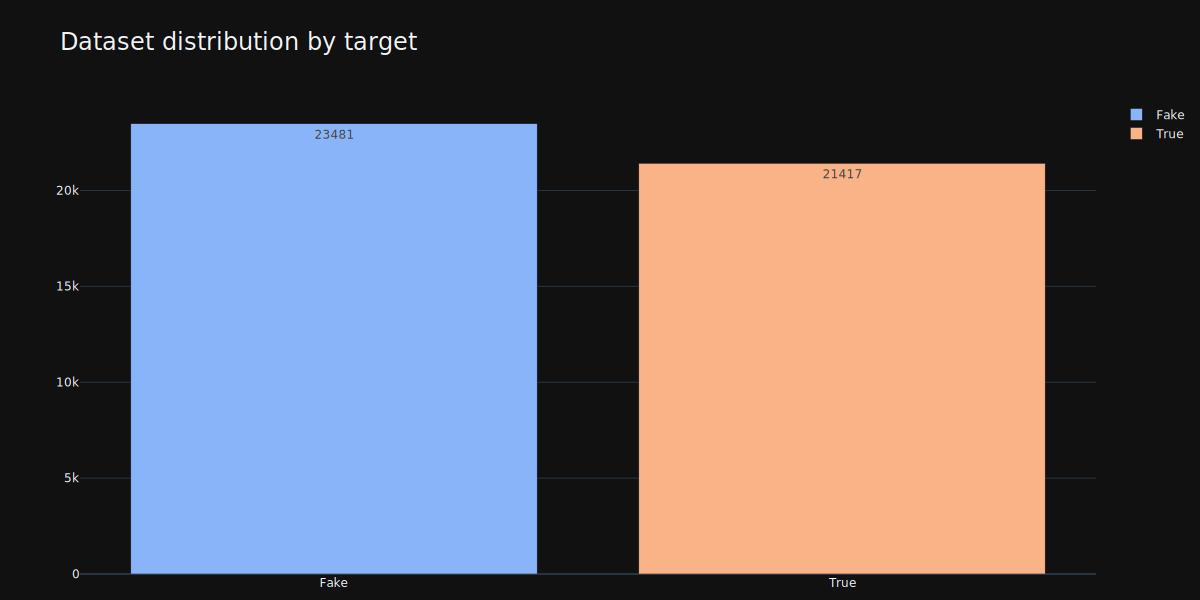

In [7]:
fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=["Fake"],
        y=[balance_counts[0]],
        name="Fake",
        text=[balance_counts[0]],
        textposition="auto",
        marker_color=blue_base,
    )
)

fig.add_trace(
    go.Bar(
        x=["True"],
        y=[balance_counts[1]],
        name="True",
        text=[balance_counts[1]],
        textposition="auto",
        marker_color=peach_base,
    )
)

fig.update_layout(
    title={"text": "Dataset distribution by target", "font": {"size": 24}},
    margin={"b": 10},
    width=1200,
    height=600,
)

fig.show("svg")

Now let's see the distribution of the length of the news

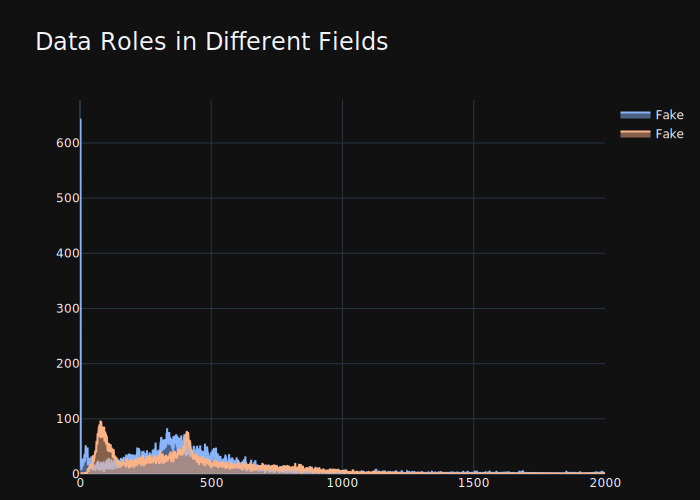

In [8]:
fake_len = df.query("label == 0")["message_len"].value_counts().sort_index()

true_len = df.query("label == 1")["message_len"].value_counts().sort_index()

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=fake_len.index,
        y=fake_len.values,
        name="Fake",
        fill="tozeroy",
        marker_color=blue_base,
    )
)

fig.add_trace(
    go.Scatter(
        x=true_len.index,
        y=true_len.values,
        name="Fake",
        fill="tozeroy",
        marker_color=peach_base,
    )
)

fig.update_layout(
    title={"text": "Data Roles in Different Fields", "font": {"size": 24}},
    margin={"b": 10},
)

fig.update_xaxes(range=[0, 2000])

fig.show("svg")

### <p style="background-color:#7287fd; font-size:150%; text-align:center; border-radius: 15px 50px;">2. Data Modeling and Preparation</p>

First we create a couple of functions for cleaning the texts. Cleaning the texts means removing any punctuations, double-spaces, emojis, links, etc. Then we lemmatize the texts and remove stop-words.

In [9]:
def clean_text(text):
    """Make text lowercase, remove text in square brackets, remove links, remove punctuation and remove words containing numbers"""

    text = re.sub(r"\s+", " ", text, flags=re.I)
    text = str(text).lower()
    text = unidecode.unidecode(text)
    text = re.sub("\[.*?\]", "", text)
    text = re.sub("https?://\S+|www\.\S+", "", text)
    text = re.sub("<.*?>+", "", text)
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)
    text = re.sub("\n", "", text)
    text = re.sub("\w*\d\w*", "", text)
    text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)

    return text


def preprocess_data(text):

    text = clean_text(text)

    stemmer = nltk.WordNetLemmatizer()

    text = " ".join(stemmer.lemmatize(word) for word in text.split(" "))

    stop_words = stopwords.words("english")
    more_words = []
    with open("/Users/alejandrodelgado/nlp/NLP/stop_words_en.txt") as f:
        for words in f:
            word = words.split(", ")
            more_words.append(word)

    more_words = [i for i in more_words for i in i]

    stop_words = stop_words + more_words
    f.close()
    text = " ".join(word for word in text.split(" ") if word not in stop_words)

    return text

We remove features we are not going to be using for detecting news

In [10]:
df = df.drop(["title", "subject", "date"], axis=1)
df.head()

text                                                label  message_len
0  Donald Trump just couldn t wish all Americans ...  0      516        
1  House Intelligence Committee Chairman Devin Nu...  0      309        
2  On Friday, it was revealed that former Milwauk...  0      600        
3  On Christmas day, Donald Trump announced that ...  0      475        
4  Pope Francis used his annual Christmas Day mes...  0      434

And now we clean the data

In [11]:
df["text"] = df["text"].apply(preprocess_data)

df.head()

text                                                label  message_len
0  donald trump american happy year leave shout e...  0      516        
1  house intelligence committee chairman devin nu...  0      309        
2  friday revealed milwaukee sheriff david clarke...  0      600        
3  christmas day donald trump announced work day ...  0      475        
4  pope francis annual christmas day message rebu...  0      434

#### <p style="background-color:#179299; font-size:150%; text-align:center; border-radius: 15px 50px;">2.1 WordCloud</p>

Let's create a couple of WordClouds extracting the 2,000 most common words on both datasets.

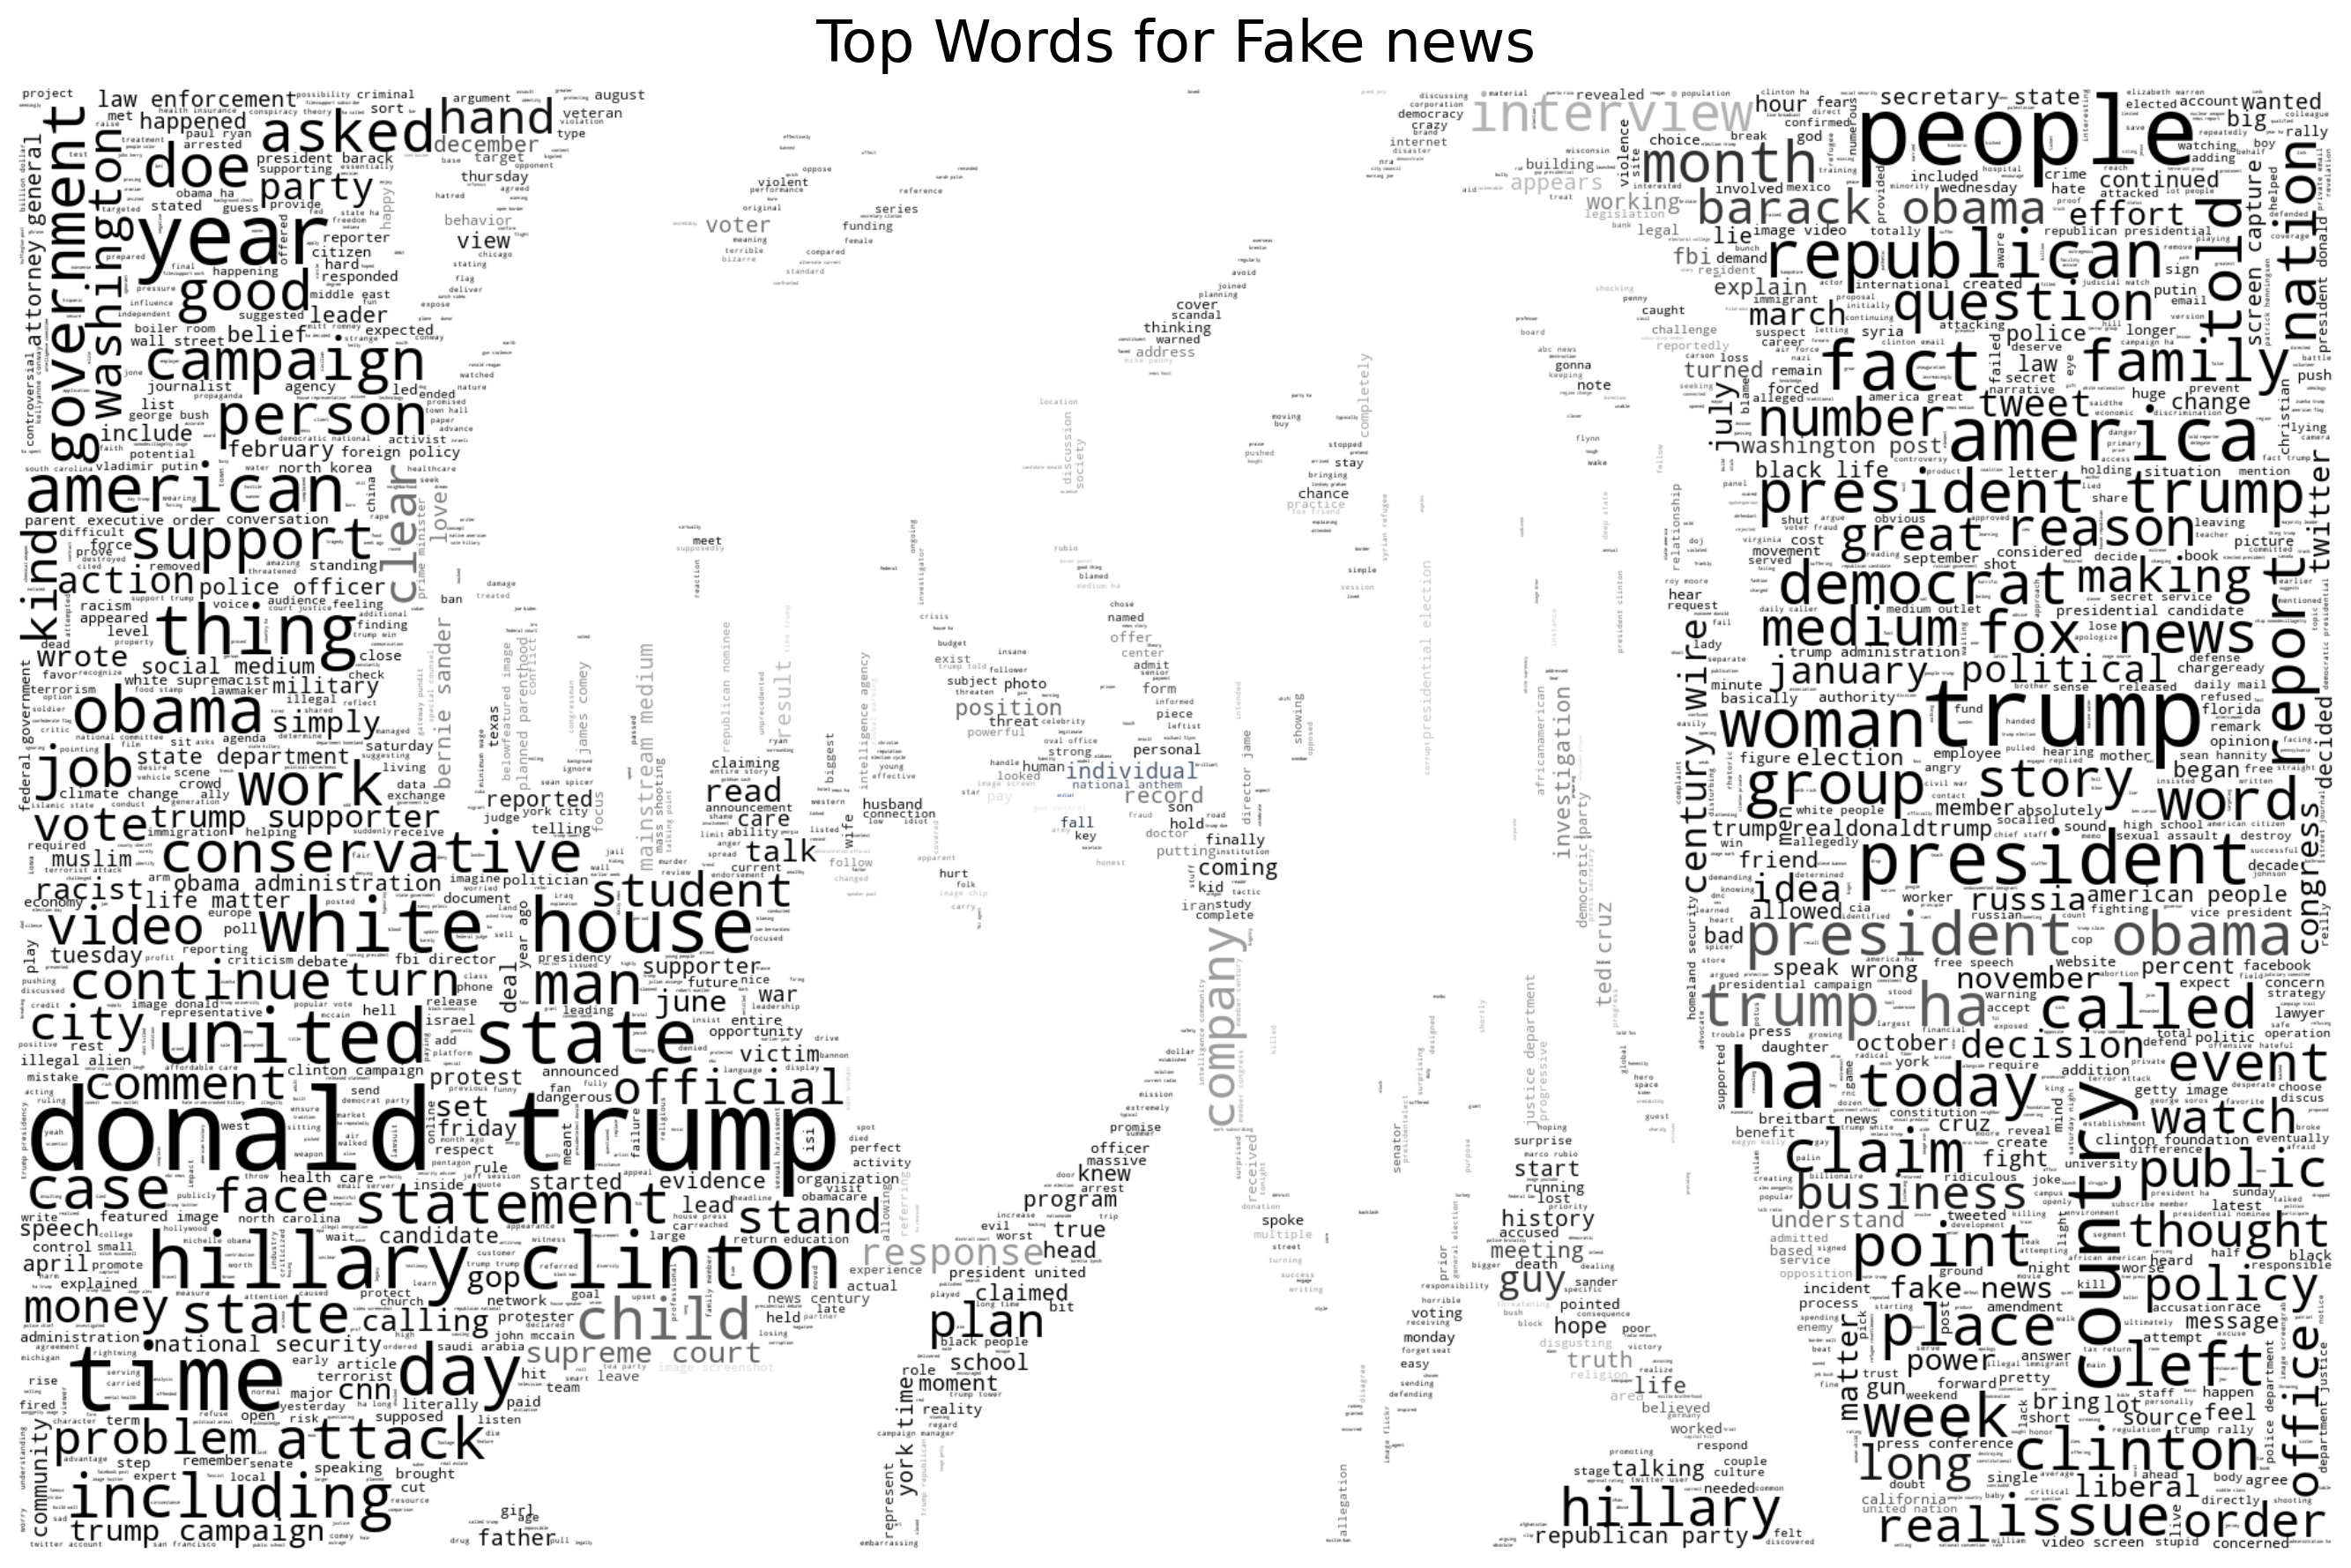

In [12]:
coloring = np.array(Image.open("582116.png"))

wc = WordCloud(background_color="white", max_words=2000, mask=coloring)

wc.generate(" ".join(text for text in df.loc[df["label"] == 0, "text"]))

img_colors = ImageColorGenerator(coloring)

plt.figure(figsize=(16, 9))
plt.title(
    "Top Words for Fake news", fontdict={"size": 24, "verticalalignment": "bottom"}
)
plt.imshow(wc.recolor(color_func=img_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

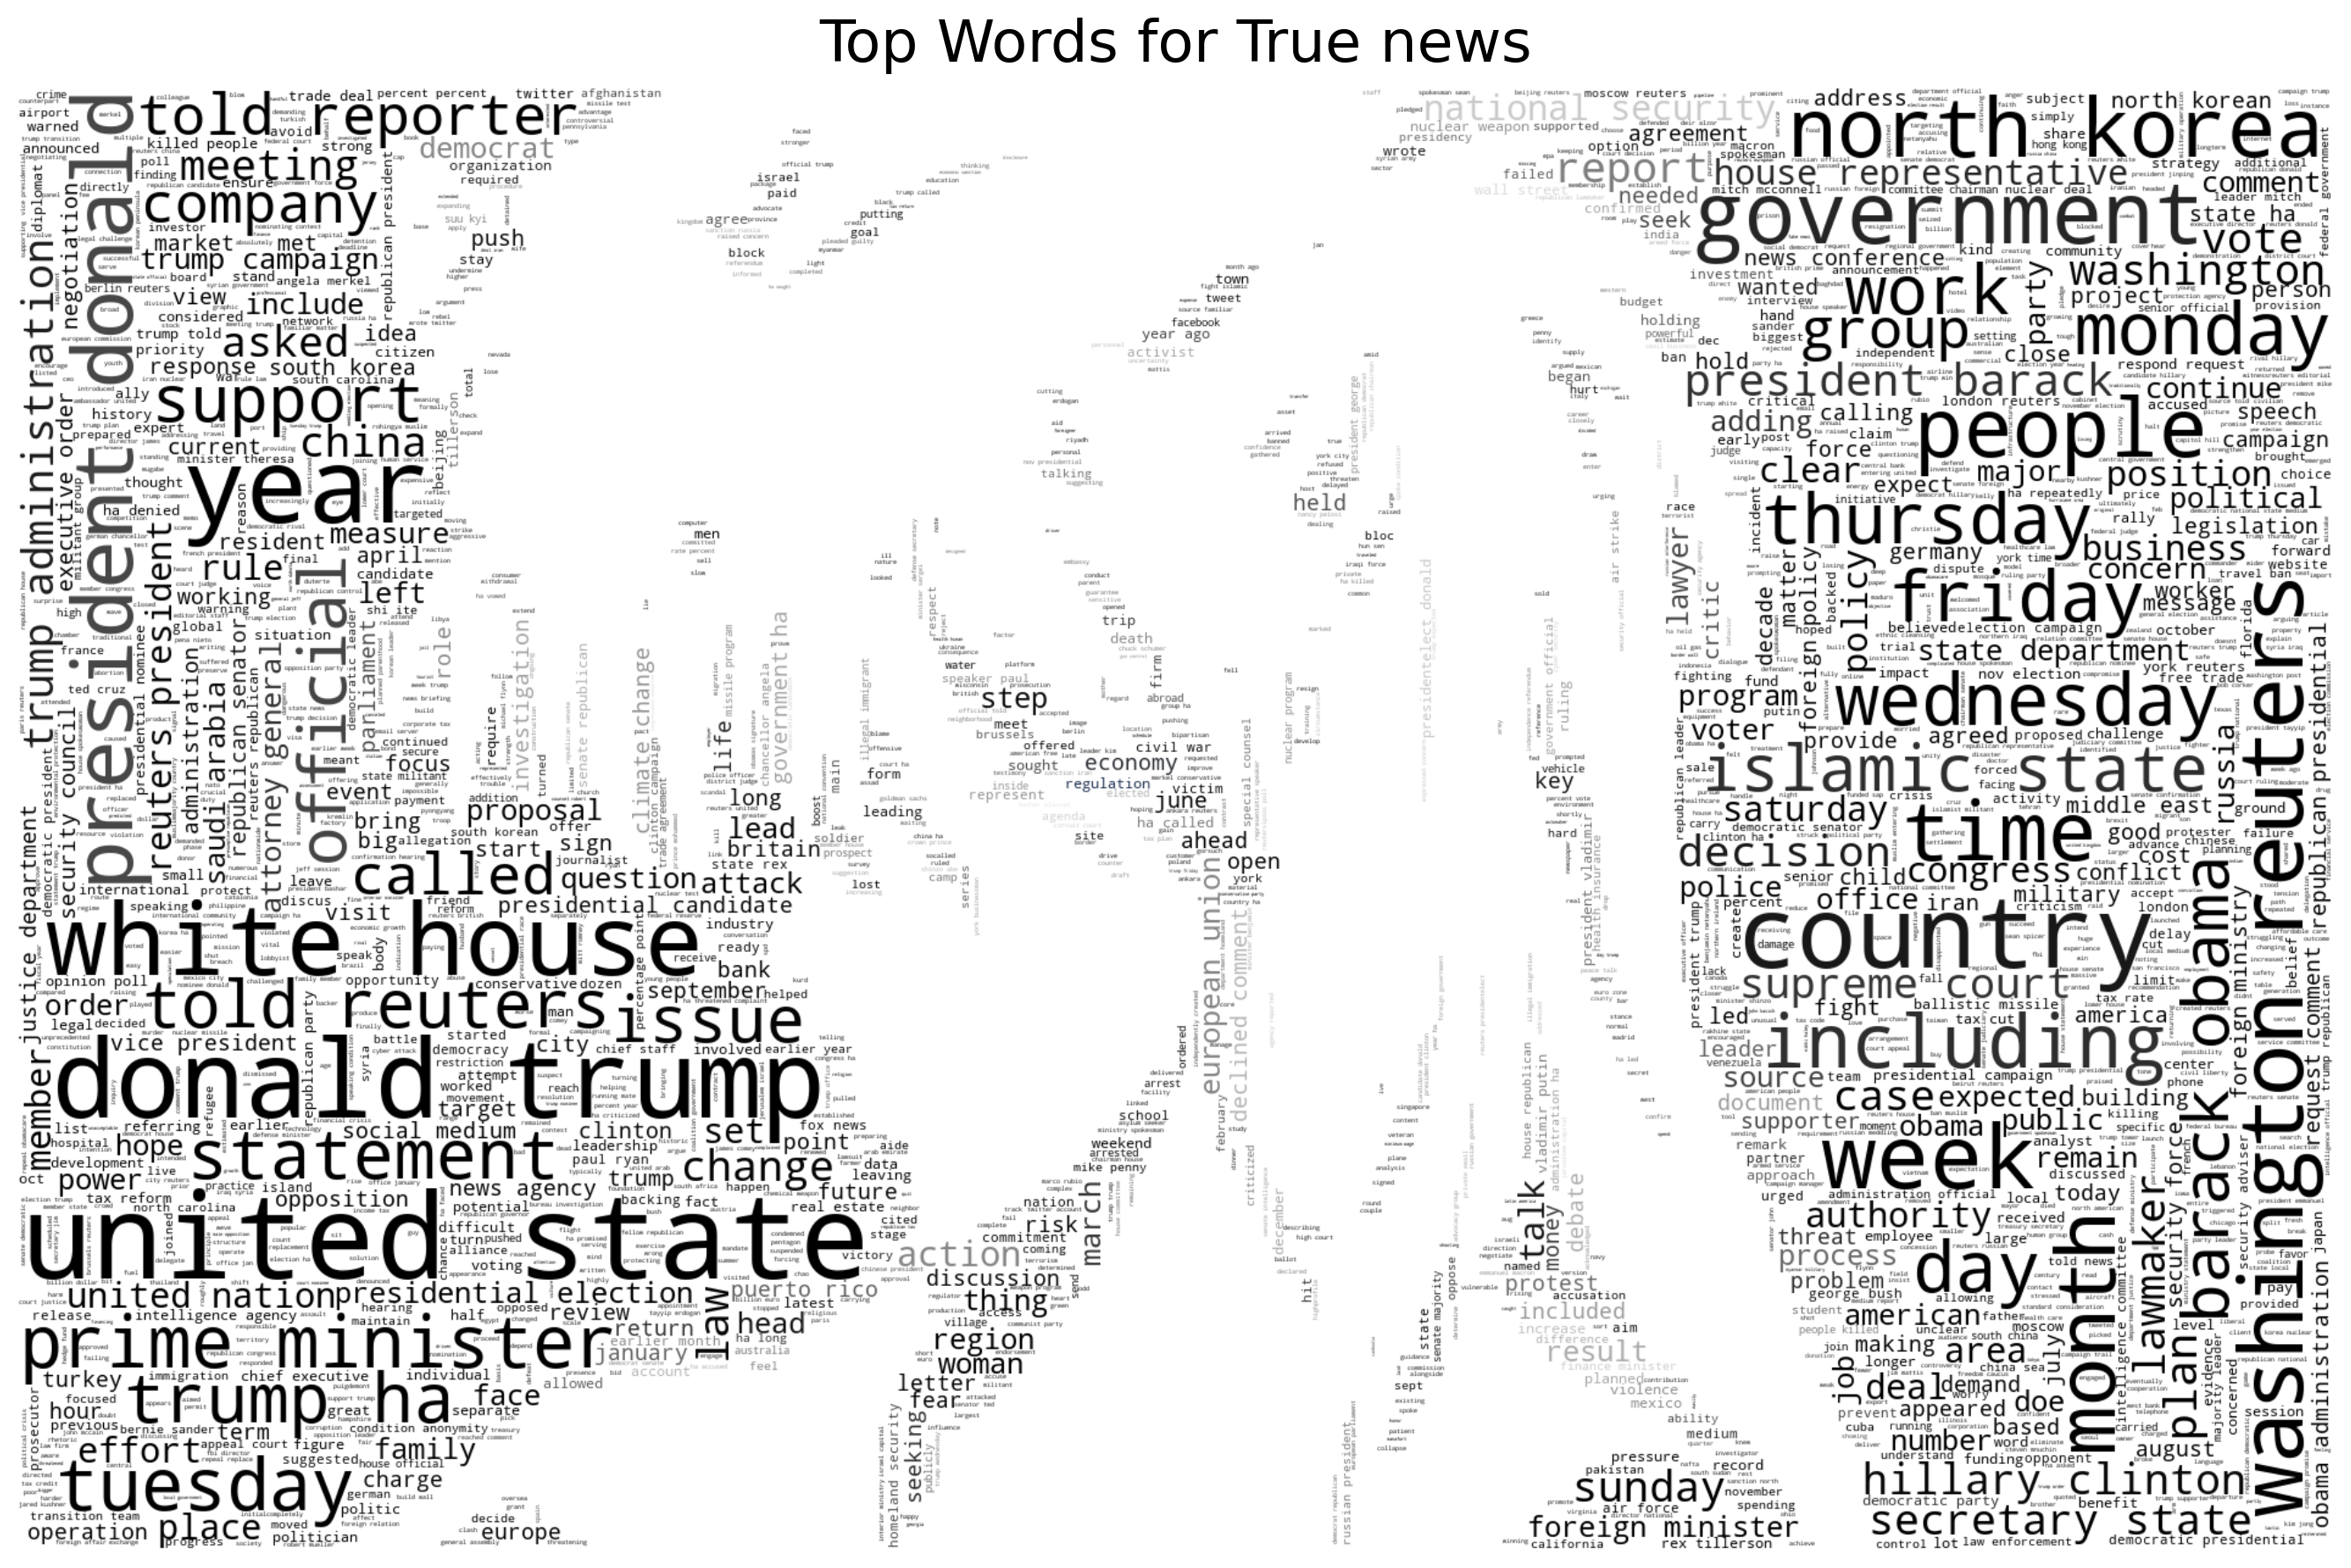

In [13]:
wc.generate(" ".join(text for text in df.loc[df["label"] == 1, "text"]))

img_colors = ImageColorGenerator(coloring)

plt.figure(figsize=(16, 9))
plt.title(
    "Top Words for True news", fontdict={"size": 24, "verticalalignment": "bottom"}
)
plt.imshow(wc.recolor(color_func=img_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

#### <p style="background-color:#179299; font-size:150%; text-align:center; border-radius: 15px 50px;">2.2 Data Preprocessing</p>

First we define our X and y variables

In [14]:
X = df["text"]
y = df["label"]

print(len(X), len(y))

44898 44898


Now we create our train, validation and test sets. I have chosen a 85%, 10% and 5% split, although this can be adjusted if needed

In [15]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.05)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.10
)

print(len(X_train), len(y_train))
print(len(X_val), len(y_val))
print(len(X_test), len(y_test))

38387 38387
4266 4266
2245 2245


We will create a first approach creating a CountVectorizer which will transform our text to numeric values with some adjustments to see if we can achieve good results with this transformed set.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(
    stop_words="english", ngram_range=(1, 2), min_df=0.1, max_df=0.7, max_features=300
)
vect.fit(X_train)

X_train_dtm = vect.transform(X_train)
X_val_dtm = vect.transform(X_val)
X_test_dtm = vect.transform(X_test)

Now let's assign the weights using sklearn's TfidfTransformer

In [17]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transf = TfidfTransformer()

tfidf_transf.fit(X_train_dtm)

X_train_tfidf = tfidf_transf.transform(X_train_dtm)
X_val_tfidf = tfidf_transf.transform(X_val_dtm)
X_test_tfidf = tfidf_transf.transform(X_test_dtm)

Now we prepare a different set in case we need to build a neural network

In [18]:
texts = df["text"]
target = df["label"]

We tokenise the text and extract the total length of vocabulary obtained for generating a corpus

In [19]:
word_tokenizer = tf.keras.preprocessing.text.Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

191293

We create a corpus and we create a matrix

In [20]:
def embed(corpus):
    return word_tokenizer.texts_to_sequences(corpus)


longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))

length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = tf.keras.preprocessing.sequence.pad_sequences(
    embed(texts), length_long_sentence, padding="post"
)

train_padded_sentences

array([[  12,    1,   20, ...,    0,    0,    0],
       [  11,  134,   83, ...,    0,    0,    0],
       [  89,  985, 4451, ...,    0,    0,    0],
       ...,
       [9135,    8, 3548, ...,    0,    0,    0],
       [ 403,    8, 3414, ...,    0,    0,    0],
       [5124,    8, 2590, ...,    0,    0,    0]], dtype=int32)

In [21]:
embeddings_dictionary = {}
embedding_dim = 300

with open("~/nlp/NLP/glove/glove.42B.300d.txt") as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype="float32")
        embeddings_dictionary[word] = vector_dimensions

In [22]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)

    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.16701999,  0.40790001,  0.49263999, ...,  0.04752   ,
         0.50178999, -0.31494999],
       [-0.0028598 ,  0.087352  ,  0.25766   , ..., -0.21547   ,
         0.38758001,  0.10931   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.52477998,  0.052079  , -0.18412   , ..., -0.11005   ,
        -0.21066   ,  0.045756  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

### <p style="background-color:#7287fd; font-size:150%; text-align:center; border-radius: 15px 50px;">3. Model Creation</p>

Now we create a function which will graph a confusion matrix showing the total of news classified as Fake and True

In [23]:
x_axes = ["Fake", "Real"]
y_axes = ["Real", "Fake"]


def conf_matrix(z, x=x_axes, y=y_axes):

    z = np.flip(z, 0)

    # Change each element of z to type string for annotation
    z_text = [[str(y) for y in x] for x in z]

    # Set-up figure
    fig = ff.create_annotated_heatmap(
        z, x=x, y=y, annotation_text=z_text, colorscale=px.colors.sequential.BuPu
    )

    # Add title
    fig.update_layout(
        title={"text": "Confusion Matrix", "font": {"size": 24}},
        xaxis={"title": "Predicted Value"},
        yaxis={"title": "Real Value"},
        width=800,
    )

    # Add Colorbar
    fig["data"][0]["showscale"] = True

    return fig.show("svg")

#### <p style="background-color:#179299; font-size:150%; text-align:center; border-radius: 15px 50px;">3.1 Naïve-Bayes Model</p>

We begin with a Naïve-Bayes model using the preprocessed data with the CountVectorized with tuned parameters

In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)

y_pred_class = nb.predict(X_val_dtm)
y_proba_class = nb.predict_proba(X_val_dtm)[:, 1]

print(f"Accuracy = {accuracy_score(y_val, y_pred_class):.2f}")

print(f"ROC-AUC = {roc_auc_score(y_val, y_proba_class):.2f}")

Accuracy = 0.92
ROC-AUC = 0.97


Now let's check the classification report

In [25]:
print(classification_report(y_val, y_pred_class, digits=3))

              precision    recall  f1-score   support

           0      0.964     0.879     0.920      2257
           1      0.877     0.963     0.918      2009

    accuracy                          0.919      4266
   macro avg      0.920     0.921     0.919      4266
weighted avg      0.923     0.919     0.919      4266



And now let's plot de confusion matrix

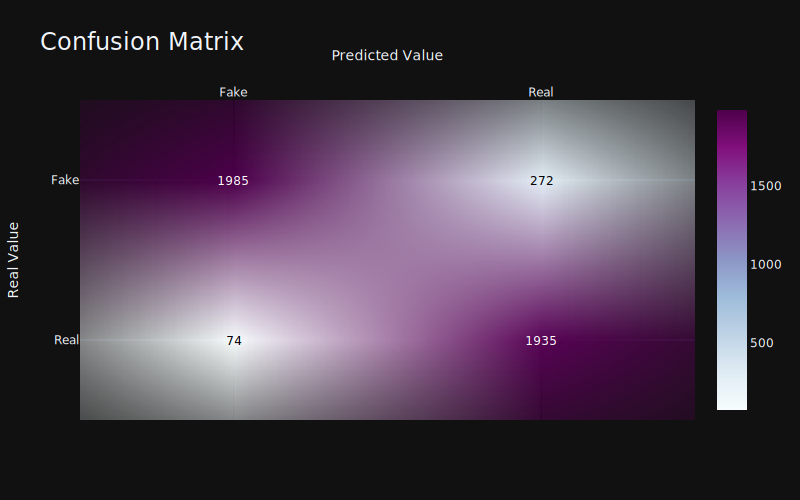

In [26]:
conf_matrix(confusion_matrix(y_val, y_pred_class))

#### <p style="background-color:#179299; font-size:150%; text-align:center; border-radius: 15px 50px;">3.2 Pipelined Naïve-Bayes Model</p>

So, in general it is not a bad model. It has high precision on both categories and a high recall as well. Let's see if it is possible to improve it with a "clean" CountVectorizer and ensembling a Pipeline

In [27]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    steps=[
        ("bow", CountVectorizer()),
        ("tfid", TfidfTransformer()),
        ("model", MultinomialNB()),
    ]
)

pipe.fit(X_train, y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfid', TfidfTransformer()),
                ('model', MultinomialNB())])

In [28]:
y_pred_class = pipe.predict(X_val)
y_proba_class = pipe.predict_proba(X_val)[:, 1]

print(f"Accuracy = {accuracy_score(y_val, y_pred_class):.2f}")

print(f"ROC-AUC = {roc_auc_score(y_val, y_proba_class):.2f}")

Accuracy = 0.92
ROC-AUC = 0.98


In [29]:
print(classification_report(y_val, y_pred_class, digits=3))

              precision    recall  f1-score   support

           0      0.941     0.915     0.928      2257
           1      0.907     0.935     0.921      2009

    accuracy                          0.925      4266
   macro avg      0.924     0.925     0.924      4266
weighted avg      0.925     0.925     0.925      4266



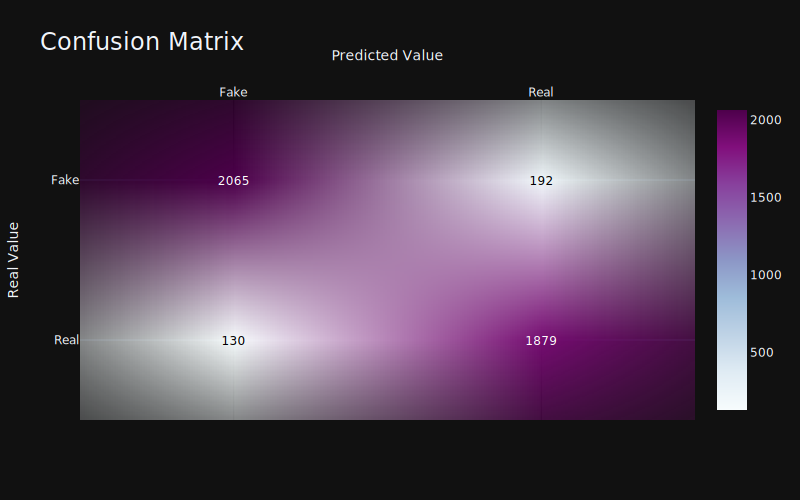

In [30]:
conf_matrix(confusion_matrix(y_val, y_pred_class))

#### <p style="background-color:#179299; font-size:150%; text-align:center; border-radius: 15px 50px;">3.3 Pipelined XGBClassifier Model</p>

So the model improved just a little bit (but any improvement is a gain). Now let's build a Pipeline with a XGB tree

In [31]:
import xgboost as xgb

pipe_xgb = Pipeline(
    steps=[
        ("bow", CountVectorizer()),
        ("tfid", TfidfTransformer()),
        (
            "model",
            xgb.XGBClassifier(
                learning_rate=0.1,
                max_depth=12,
                n_estimators=120,
                # use_label_encoder=False,
                eval_metric="auc",
            ),
        ),
    ]
)

pipe_xgb.fit(X_train, y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfid', TfidfTransformer()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='auc',
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=12, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=120,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [32]:
y_pred_class = pipe_xgb.predict(X_val)
y_proba_class = pipe_xgb.predict_proba(X_val)[:, 1]

print(f"Accuracy = {accuracy_score(y_val, y_pred_class):.3f}")

print(f"ROC-AUC = {roc_auc_score(y_val, y_proba_class):.3f}")

Accuracy = 0.996
ROC-AUC = 0.999


In [33]:
print(classification_report(y_val, y_pred_class, digits=4))

              precision    recall  f1-score   support

           0     0.9969    0.9956    0.9962      2257
           1     0.9950    0.9965    0.9958      2009

    accuracy                         0.9960      4266
   macro avg     0.9960    0.9960    0.9960      4266
weighted avg     0.9960    0.9960    0.9960      4266



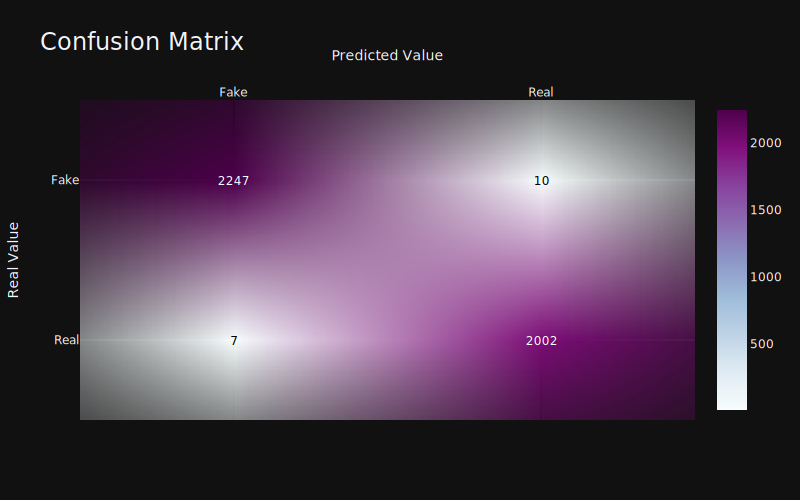

In [34]:
conf_matrix(confusion_matrix(y_val, y_pred_class))

It can be seen the XGB model has a better performance than the Naïve-Bayes one. Let's see a ROC-AUC Curve to see how it behaves

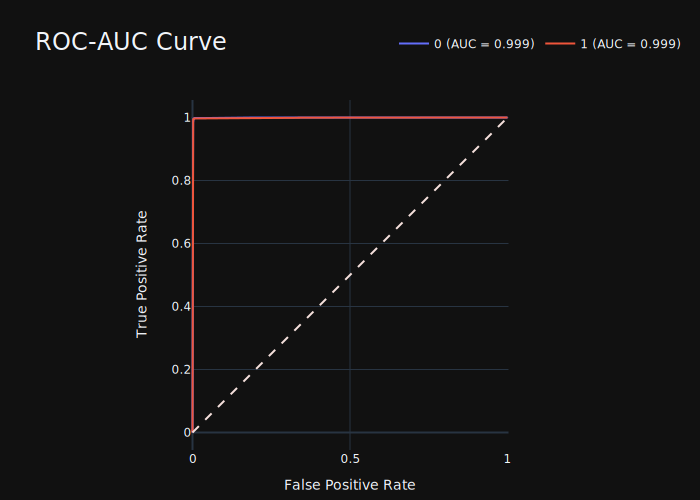

In [56]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve

y_onehot = pd.get_dummies(y_val, columns=pipe_xgb.classes_)
y_scores = pipe_xgb.predict_proba(X_val)

fig = go.Figure()
fig.add_shape(
    type="line", line={"dash": "dash", "color": rose_base}, x0=0, x1=1, y0=0, y1=1
)

for i in range(y_scores.shape[1]):
    y_true = y_onehot.iloc[:, i]
    y_score = y_scores[:, i]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)

    name = f"{y_onehot.columns[i]} (AUC = {auc_score:.3f})"

    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode="lines"))

fig.update_layout(
    title={"text": "ROC-AUC Curve", "font": {"size": 24}},
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    yaxis={"scaleanchor": "x", "scaleratio": 1},
    xaxis={"constrain": "domain"},
    width=700,
    height=500,
    margin={"b": 10, "l": 10, "r": 10},
    legend={
        "orientation": "h",
        "yanchor": "bottom",
        "y": 1.12,
        "xanchor": "right",
        "x": 1,
    },
)

fig.show("svg")

Now let's see a Precision - Recall curve 

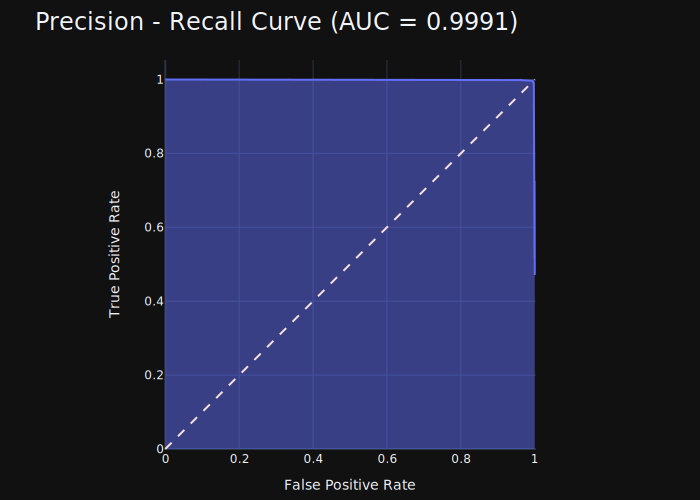

In [36]:
precision, recall, threshold = precision_recall_curve(y_val, y_proba_class)

fig = px.area(
    x=recall,
    y=precision,
    labels={"x": "Recall", "y": "Precision"},
    width=700,
    height=500,
)

fig.add_shape(
    type="line", line={"dash": "dash", "color": rose_base}, x0=0, x1=1, y0=0, y1=1
)

fig.update_layout(
    title={
        "text": f"Precision - Recall Curve (AUC = {auc(fpr, tpr):.4f})",
        "font": {"size": 24},
    },
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    yaxis={"scaleanchor": "x", "scaleratio": 1},
    xaxis={"constrain": "domain"},
    width=700,
    height=500,
    margin={"b": 10, "l": 10, "r": 10},
)

fig.show("svg")

Let's check the precision

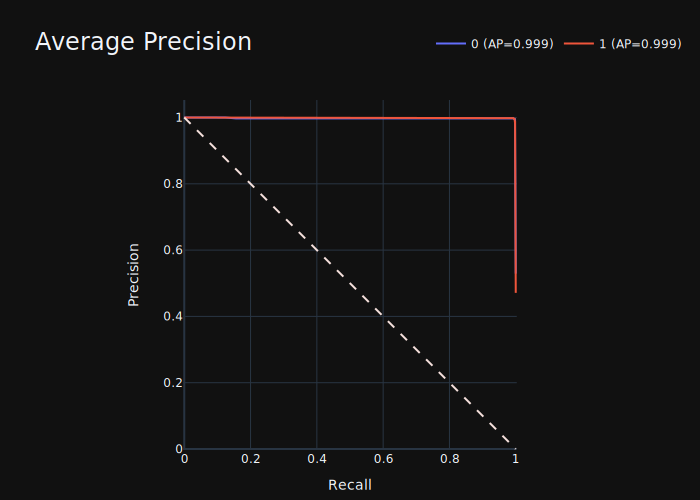

In [55]:
from sklearn.metrics import average_precision_score

y_onehot = pd.get_dummies(y_val, columns=pipe_xgb.classes_)
y_scores = pipe_xgb.predict_proba(X_val)

fig = go.Figure()
fig.add_shape(
    type="line", line={"dash": "dash", "color": rose_base}, x0=0, x1=1, y0=1, y1=0
)

for i in range(y_scores.shape[1]):
    y_true = y_onehot.iloc[:, i]
    y_score = y_scores[:, i]

    precision, recall, _ = precision_recall_curve(y_true, y_score)
    auc_score = average_precision_score(y_true, y_score)

    name = f"{y_onehot.columns[i]} (AP={auc_score:.3f})"
    fig.add_trace(go.Scatter(x=recall, y=precision, name=name, mode="lines"))

fig.update_layout(
    title={"text": "Average Precision", "font": {"size": 24}},
    xaxis_title="Recall",
    yaxis_title="Precision",
    yaxis={"scaleanchor": "x", "scaleratio": 1},
    xaxis={"constrain": "domain"},
    width=700,
    height=500,
    margin={"b": 10, "l": 10, "r": 10},
    legend={
        "orientation": "h",
        "yanchor": "bottom",
        "y": 1.12,
        "xanchor": "right",
        "x": 1,
    },
)
fig.show("svg")

And now, let's just do a mini run in the test set.

In [37]:
y_pred_class_test = pipe_xgb.predict(X_test)
y_proba_class_test = pipe_xgb.predict_proba(X_test)[:, 1]

print(f"Accuracy = {accuracy_score(y_test, y_pred_class_test):.5f}")

print(f"ROC-AUC = {roc_auc_score(y_test, y_proba_class_test):.5f}")

Accuracy = 0.99866
ROC-AUC = 0.99955


In [38]:
print(classification_report(y_test, y_pred_class_test, digits=5))

              precision    recall  f1-score   support

           0    0.99830   0.99915   0.99872      1175
           1    0.99906   0.99813   0.99860      1070

    accuracy                        0.99866      2245
   macro avg    0.99868   0.99864   0.99866      2245
weighted avg    0.99866   0.99866   0.99866      2245



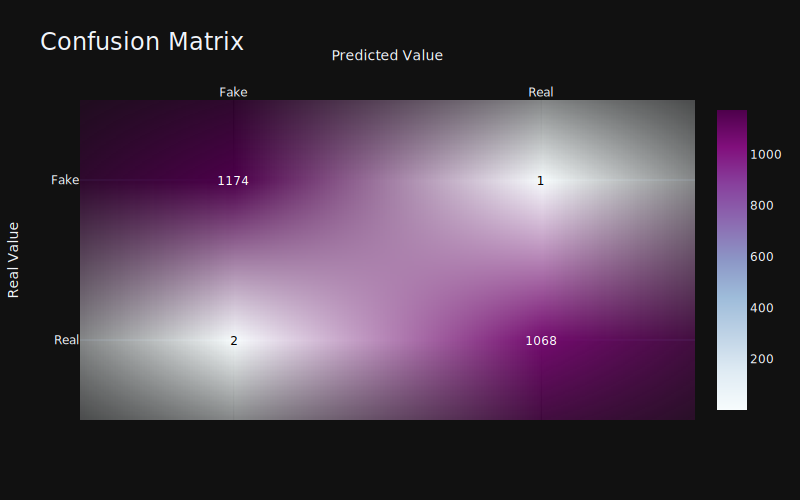

In [39]:
conf_matrix(confusion_matrix(y_test, y_pred_class_test))

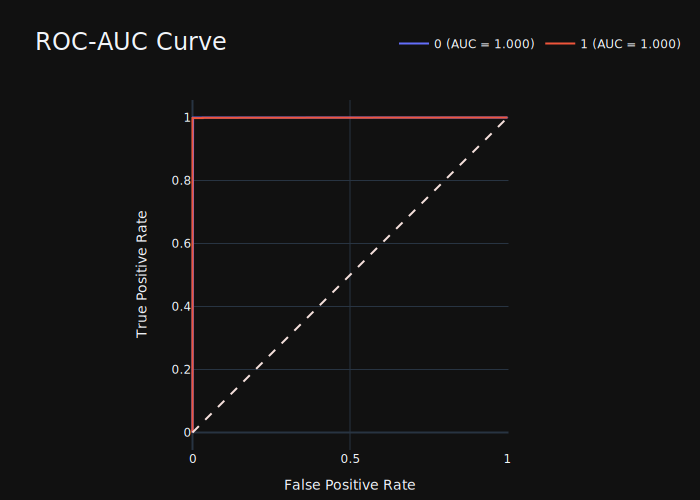

In [54]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve

y_onehot = pd.get_dummies(y_test, columns=pipe_xgb.classes_)
y_scores = pipe_xgb.predict_proba(X_test)

fig = go.Figure()
fig.add_shape(
    type="line", line={"dash": "dash", "color": rose_base}, x0=0, x1=1, y0=0, y1=1
)

for i in range(y_scores.shape[1]):
    y_true = y_onehot.iloc[:, i]
    y_score = y_scores[:, i]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)

    name = f"{y_onehot.columns[i]} (AUC = {auc_score:.3f})"

    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode="lines"))

fig.update_layout(
    title={"text": "ROC-AUC Curve", "font": {"size": 24}},
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    yaxis={"scaleanchor": "x", "scaleratio": 1},
    xaxis={"constrain": "domain"},
    width=700,
    height=500,
    margin={"b": 10, "l": 10, "r": 10},
    legend={
        "orientation": "h",
        "yanchor": "bottom",
        "y": 1.12,
        "xanchor": "right",
        "x": 1,
    },
)

fig.show("svg")

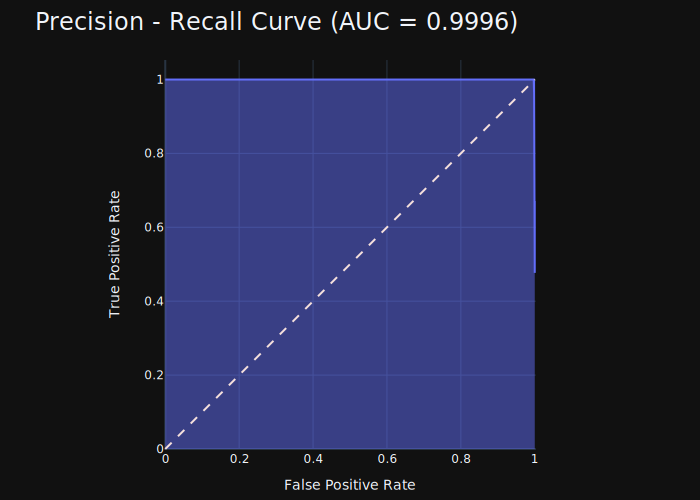

In [41]:
precision, recall, threshold = precision_recall_curve(y_test, y_proba_class_test)

fig = px.area(
    x=recall,
    y=precision,
    labels={"x": "Recall", "y": "Precision"},
    width=700,
    height=500,
)

fig.add_shape(
    type="line", line={"dash": "dash", "color": rose_base}, x0=0, x1=1, y0=0, y1=1
)

fig.update_layout(
    title={
        "text": f"Precision - Recall Curve (AUC = {auc(fpr, tpr):.4f})",
        "font": {"size": 24},
    },
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    yaxis={"scaleanchor": "x", "scaleratio": 1},
    xaxis={"constrain": "domain"},
    width=700,
    height=500,
    margin={"b": 10, "l": 10, "r": 10},
)

fig.show("svg")

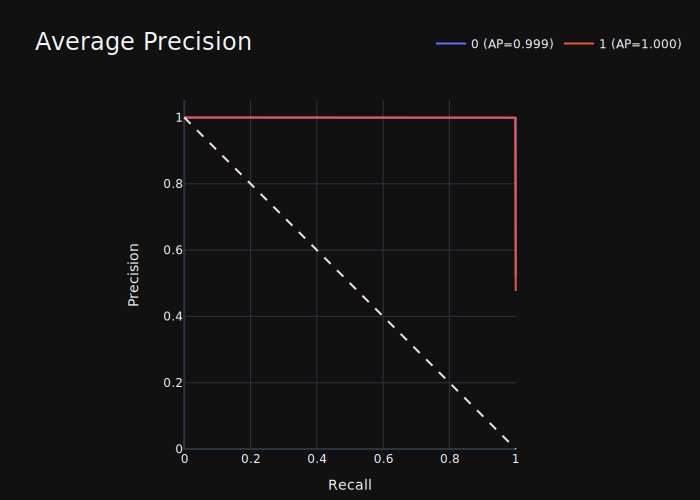

In [53]:
y_onehot = pd.get_dummies(y_test, columns=pipe_xgb.classes_)
y_scores = pipe_xgb.predict_proba(X_test)

fig = go.Figure()
fig.add_shape(
    type="line", line={"dash": "dash", "color": rose_base}, x0=0, x1=1, y0=1, y1=0
)

for i in range(y_scores.shape[1]):
    y_true = y_onehot.iloc[:, i]
    y_score = y_scores[:, i]

    precision, recall, _ = precision_recall_curve(y_true, y_score)
    auc_score = average_precision_score(y_true, y_score)

    name = f"{y_onehot.columns[i]} (AP={auc_score:.3f})"
    fig.add_trace(go.Scatter(x=recall, y=precision, name=name, mode="lines"))

fig.update_layout(
    title={"text": "Average Precision", "font": {"size": 24}},
    xaxis_title="Recall",
    yaxis_title="Precision",
    yaxis={"scaleanchor": "x", "scaleratio": 1},
    xaxis={"constrain": "domain"},
    width=700,
    height=500,
    margin={"b": 10, "l": 10, "r": 10},
    legend={
        "orientation": "h",
        "yanchor": "bottom",
        "y": 1.12,
        "xanchor": "right",
        "x": 1,
    },
)
fig.show("svg")

So, in general, it can be seen the XGB model has a nice performance. There should not be a need to build a larger, heavier model with a neural network as it will take a lot of computational resources for training due to the number of parameters needed to do so. 

Also, we already have a 99% of precision and recall, which in reality already is as high as it would be recommeded to go since having a score of 100% would mean an overfitting and that would not be recommended to have.